In [2]:
# -*- coding: utf-8 -*-

## standard packages
import numpy as np
import os
import datetime
from importlib import reload

import configparser
import json

## Database
import sqlite3

# Data analysis
import matplotlib.pyplot as plt

import sklearn
from sklearn.decomposition import PCA

from collections import Counter

import src.utils as utils
import src.dataAnalysis as an


# load and connect to Database


In [3]:
#database.close()
database = utils.DataBase(os.getcwd() + "/src/DataBase/carStats.db")

In [4]:
database.connect()

In [5]:
cursor = database.getCursor()
adData = database.execute("""SELECT * FROM car""")

In [6]:
adData = np.array(adData)
print("size of the dataset: ", adData.shape)

size of the dataset:  (76972, 46)


## example with keys

In [7]:
cursor = database.getCursor()
keys = []
for desc in cursor.description:
    keys.append(desc[0])
for i, v in enumerate(keys):
    print (i, v)
    print ("   ", adData[0][i])

0 cubiccapacity
    1.400 cm³
1 adspecificsmodeldescription
    Escort Ghia 1.4 mit guten Verdeck!!!!!
2 manufacturercolorname
    weiß
3 featurevariants
    None
4 consumption
    No Information
5 adspecificsfuel
    PETROL
6 adspecificsmake
    Ford
7 firstseen
    16.08.2017
8 climatisation
    Keine Klimaanlage oder -automatik
9 dealercity
    Weiden
10 description
    weißes Escort Cabrio mit roten, guten Verdeck,innen Velour grau,5-Gang,Preis 600Euro ohne Tüv unaufbereitet wie steht
*auch mobil erreichbar unter 0175-5356136
*
11 adfirstregmonth
    2
12 interior
    Velours, Grau
13 adprice
    600.0
14 adspecificsmakeid
    9000
15 lastseen
    2017-08-19
16 adsegment
    Car
17 isdealer
    True
18 fuel
    Benzin
19 adspecificsmodel
    Escort
20 adspecificsmakemodel
    Ford Escort
21 hu
    No Information
22 firstregistration
    02/1988
23 adcurrency
    EUR
24 parkassist
    No Information
25 adspecificshsn
    928
26 adid
    2259203
27 airbag
    No Information
28 adcond

## get the important data

we are not (yet) interested in all the info in the DB, so we choose for now only numeric data

some of the following variables will definitely correlate with the car price (e.g. mileage and power), whereas others most likely will only be noise (e.g. dealer zip).

In [8]:
sqlCommand = """SELECT adid, 
                adprice,
                
                adspecificsfuel,
                consumption,
                emission,
                cubiccapacity,
                power,
                mileage,
                
                adspecificsmake,
                adspecificsmodel,
                adspecificsmakeid,
                adspecificsmodelid,
                adfirstregyear,
                category,
                manufacturercolorname,
                
                dealerzip,
                
                firstseen,
                lastseen
                
                FROM car
                ORDER BY adid
                """

orderedData = database.execute(sqlCommand)


In [9]:
cursor = database.getCursor()
keys = []
for i in cursor.description:
    keys.append(i[0])
    
for i, v in enumerate(keys):
    print(i, v)

0 adid
1 adprice
2 adspecificsfuel
3 consumption
4 emission
5 cubiccapacity
6 power
7 mileage
8 adspecificsmake
9 adspecificsmodel
10 adspecificsmakeid
11 adspecificsmodelid
12 adfirstregyear
13 category
14 manufacturercolorname
15 dealerzip
16 firstseen
17 lastseen


In [10]:
# put data (list) into an array
orderedArr = np.array(orderedData)

In [11]:
Counter(orderedArr[:, 2])

Counter({'PETROL': 47356,
         'DIESEL': 27651,
         None: 697,
         'LPG': 960,
         'OTHER': 35,
         'CNG': 187,
         'ELECTRICITY': 30,
         'HYBRID': 51,
         'HYBRID_DIESEL': 3,
         'HYDROGENIUM': 2})

# preprocessing

the following step is to process the data which is mostly strings in to comparable numerical data.

In [12]:
for arr in orderedArr:
    # convert fuel type to numbers 1-10
    if arr[2] and 'No Information' not in arr[2]:
        if 'PETROL' in arr[2]:
            arr[2] = 1
        elif 'DIESEL' in arr[2]:
            arr[2] = 2
        #elif 'HYBRID_DIESEL' in arr[2]:
        #    arr[2] = 3
        #elif 'CNG' in arr[2]:
        #    arr[2] = 4   
        #elif 'HYDROGENIUM' in arr[2]:
        #    arr[2] = 5
        #elif 'ELECTRICITY' in arr[2]:
        #    arr[2] = 6     
        #elif 'HYBRID' in arr[2]:
        #    arr[2] = 7      
        #elif 'LPG'in arr[2]:
        #    arr[2] = 8    
        #elif 'OTHER' in arr[2]:
        #    arr[2] = 9   
        else: #None
            #arr[2] = 10
            arr[2] = None
    else:
        arr[2] = None
    
    
    # process fuel consumption
    if arr[3] and 'No Information' not in arr[3] and 'l/100km' in arr[3]:
        try:
            arr[3] = float(arr[3][1:arr[3].find(' l/100km')].replace(',', '.'))
        except Exception as e:
            print (e)
            print (arr)
            break
    #elif arr[3] and 'No Information' not in arr[3]:
    #    arr[3] -> if cng or electricity
    else:
        arr[3] = None
    # process emission values
    if arr[4] and 'No Information' not in arr[4]:
        arr[4] = float(arr[4][1:arr[4].find(' g/km (kombiniert)')].replace(',', '.'))
    else:
        arr[4] = None
    # process cubiccapacity
    if arr[5] and 'No Information' not in arr[5]:
        arr[5] = int(arr[5][:arr[5].find(' cm')].replace('.', ''))
    else:
        arr[5] = None
    # process power
    if arr[6] and 'No Information' not in arr[6]:
        arr[6] = int(arr[6][:arr[6].find(' kW')].replace('.', ''))
    else:
        arr[6] = None
    # process mileage
    if arr[7] and 'No Information' not in arr[7]:
        arr[7] = int(arr[7].replace('.', '')[:-3])
    else:
        arr[7] = None

In [13]:
#Example:
orderedArr[0]

array([2259203, 600.0, 1, None, None, 1400, 54, 130000, 'Ford', 'Escort',
       '9000', '11', 1988, 'Cabrio / Roadster', 'weiß', 92637,
       '16.08.2017', '2017-08-19'], dtype=object)

# first look at the data
without machine learning and big data techniques

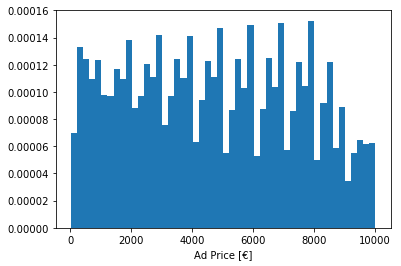

In [14]:
price = []

for arr in orderedArr:
    if arr[2]:
        price.append(arr[1])
price.sort()

plt.hist(price, bins=50, normed=True)
plt.xlabel('Ad Price [€]')
plt.show()

note: on a first glance, the price information is not at all gaussian and even some structure can be seen in this simple histogram plot. However, since the search mask from the data mining is selecting cars depending on their price, it is likely that this data is not representative for the whole car market.

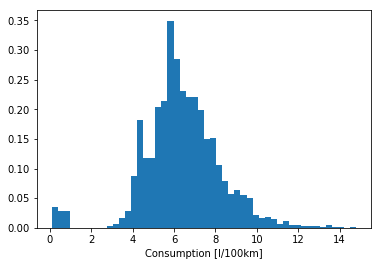

In [14]:
consumption = []

for arr in orderedArr:
    if arr[3]:
        consumption.append(arr[3]) # remove NoneTypes
consumption.sort()
consumption = consumption[:-100] # remove extreme outliers

plt.hist(consumption, bins=50, normed=True)
plt.xlabel('Consumption [l/100km]')
plt.show()

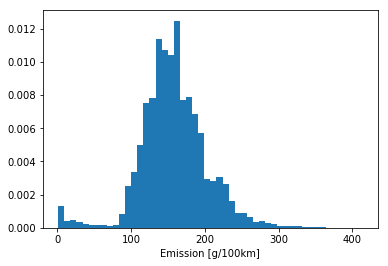

In [15]:
emission = []

for arr in orderedArr:
    if arr[4]:
        emission.append(arr[4]) # remove NoneTypes
emission.sort()
emission = emission[:-30] # remove extreme outliers

plt.hist(emission, bins=50, normed=True)
plt.xlabel('Emission [g/100km]')
plt.show()

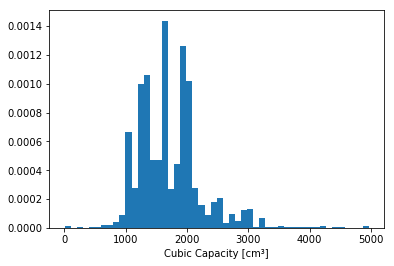

In [16]:
cubiccapacity = []

for arr in orderedArr:
    if arr[5]:
        cubiccapacity.append(arr[5]) # remove NoneTypes
cubiccapacity.sort()
cubiccapacity = cubiccapacity[:-100] # remove extreme outliers

plt.hist(cubiccapacity, bins=50, normed=True)
plt.xlabel('Cubic Capacity [cm³]')
plt.show()

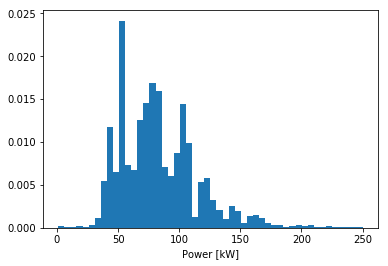

In [17]:
power = []

for arr in orderedArr:
    if arr[6]:
        power.append(arr[6]) # remove NoneTypes
power.sort()
power = power[:-100] # remove extreme outliers

plt.hist(power, bins=50, normed=True)
plt.xlabel('Power [kW]')
plt.show()

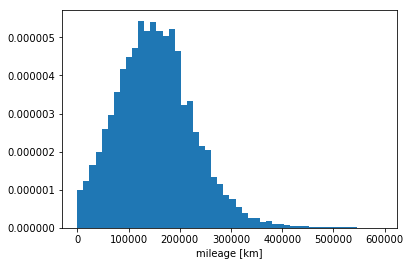

In [18]:
mileage = []

for arr in orderedArr:
    if arr[7]:
        mileage.append(arr[7]) # remove NoneTypes
mileage.sort()
mileage = mileage[:-100] # remove extreme outliers

plt.hist(mileage, bins=50, normed=True)
plt.xlabel('mileage [km]')
plt.show()

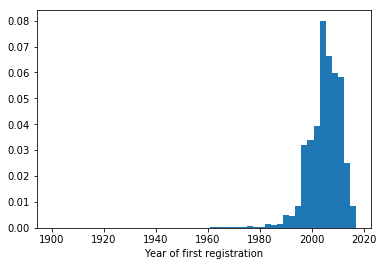

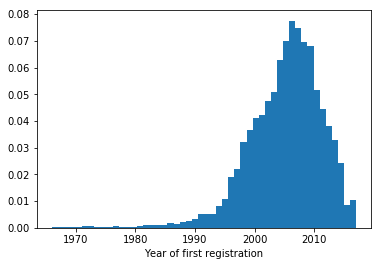

In [19]:
firstregyear = []

for arr in orderedArr:
    if arr[12]:
        firstregyear.append(arr[12]) # remove NoneTypes
firstregyear.sort()
#firstregyear = firstregyear[100:] # remove extreme outliers

plt.hist(firstregyear, bins=50, normed=True)
plt.xlabel('Year of first registration')
plt.show()

plt.hist(firstregyear[100:], bins=50, normed=True)
plt.xlabel('Year of first registration')
plt.show()

# second look at the data - with ML techniques

Now let's do some real stuff

- first, get all the data that can actually be translated into numerical data, or is already

- then, normalize and preprocess it if necessary

- now, we could do something like a PCA, linear regression, decision trees, etc.

In [15]:
for i, v in enumerate(keys):
    print(i, v)

0 adid
1 adprice
2 adspecificsfuel
3 consumption
4 emission
5 cubiccapacity
6 power
7 mileage
8 adspecificsmake
9 adspecificsmodel
10 adspecificsmakeid
11 adspecificsmodelid
12 adfirstregyear
13 category
14 manufacturercolorname
15 dealerzip
16 firstseen
17 lastseen


In [142]:
i = 1
orderedArr[i, 8], orderedArr[i, 9], orderedArr[i, 13]
len(Counter(orderedArr[:, 8]).keys())

78

In [16]:
categoryList = [0, 10, 11, 13, 14, 1, 2, 3, 4, 5, 6, 7, 12] #first category variables, then continuous variables
#categoryList = [1, 2, 3, 4, 5, 6, 7, 12]
orderedNumericalData = orderedArr[:, categoryList]
orderedNumericalData.shape

(76972, 13)

In [22]:
orderedNumericalData[0]

array([2259203, 600.0, 1, None, None, 1400, 54, 130000, '9000', '11', 1988], dtype=object)

In [18]:
def removeNones(data):
    ''' data should be 2D'''
    noNones = []
    for i in data:
        noEmpty = True
        for j in i:
            if not j:
                noEmpty = False
        if noEmpty:
            noNones.append(i)
    return np.array(noNones)

noNones = removeNones(orderedNumericalData)
orderedNumericalData.shape, noNones.shape

((76972, 13), (48686, 13))

In [24]:
categoryList

[0, 10, 11, 13, 14, 1, 2, 3, 4, 5, 6, 7, 12]

In [25]:
def  categoryToBinaryMatrix(data, categoryColumnIndex):
    binaries = []
    
    for i, key in enumerate(Counter(data[:, categoryColumnIndex]).keys()):
        binaries.append( [int(1*boolean) for boolean in data[:, categoryColumnIndex] == key] )
    return np.transpose(np.array(binaries))

makeIDmatrix = categoryToBinaryMatrix(noNones, 1)
modelIDmatrix = categoryToBinaryMatrix(noNones, 2)
categorymatrix = categoryToBinaryMatrix(noNones, 3)
colormatrix = categoryToBinaryMatrix(noNones, 4)
makeIDmatrix.shape, modelIDmatrix.shape, categorymatrix.shape, colormatrix.shape

((48686, 53), (48686, 123), (48686, 20), (48686, 4903))

In [26]:
extendedNoNones = np.hstack([noNones, makeIDmatrix, modelIDmatrix, categorymatrix])
noNones.shape, extendedNoNones.shape

((48686, 13), (48686, 209))

In [29]:
# another preprocessing step: remove outliers

#noNones4 = noNones.copy()
noNones4 = extendedNoNones[:, 5:]

for i in range(8):
    col = noNones4[:, i].astype(float)
    colMean = np.mean(col)
    colStd = np.std(col)
    
    outliers = []
    for c in col:
        outliers.append(colMean - 3*colStd < c < colMean + 3*colStd)
        
    noNones4 = noNones4[outliers]
    print(noNones4.shape)

(48686, 204)
(48686, 204)
(48685, 204)
(48660, 204)
(48308, 204)
(48238, 204)
(48098, 204)
(48072, 204)


In [70]:
# normalize data (min-max normalization)
normalized = np.zeros_like(noNones4)

for i in range(noNones4.shape[1]):
    if i < 8:
        col = noNones4[:, i].astype(float)
        normalized[:, i] = (col-np.min(col))/(np.max(col) - np.min(col))
    else:
        normalized[:, i] = noNones4[:, i]



In [71]:
normalized.shape

(48072, 204)

In [72]:
for i, v in enumerate(keys):
    print(i, v)
print(categoryList)

0 adid
1 adprice
2 adspecificsfuel
3 consumption
4 emission
5 cubiccapacity
6 power
7 mileage
8 adspecificsmake
9 adspecificsmodel
10 adspecificsmakeid
11 adspecificsmodelid
12 adfirstregyear
13 category
14 manufacturercolorname
15 dealerzip
16 firstseen
17 lastseen
[0, 10, 11, 13, 14, 1, 2, 3, 4, 5, 6, 7, 12]


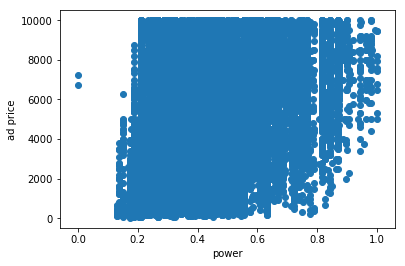

In [73]:
i=5
plt.scatter(normalized[:, i], noNones4[:, 0])
plt.xlabel(keys[categoryList[i+5]])
#plt.xlabel('year first registered')
plt.ylabel('ad price')
plt.show()

In [74]:
for i, c in enumerate(categoryList):
    print (i, keys[c])

0 adid
1 adspecificsmakeid
2 adspecificsmodelid
3 category
4 manufacturercolorname
5 adprice
6 adspecificsfuel
7 consumption
8 emission
9 cubiccapacity
10 power
11 mileage
12 adfirstregyear


## supervised learning

In [75]:
oneThird = int(normalized.shape[0]/3)
oneFifth = int(normalized.shape[0]/5)
normalized.shape, normalized.shape[0]/3, normalized.shape[0]/5

((48072, 204), 16024.0, 9614.4)

In [103]:
from sklearn.linear_model import LinearRegression

LR1 = LinearRegression(normalize=True)

In [104]:
normalized[100]

array([0.6943887775551102, 0.0, 0.036164844407064765, 0.28939828080229224,
       0.2008059100067159, 0.24083769633507854, 0.1187876340574116,
       0.8333333333333334, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

In [191]:
train_set_x = normalized[:oneFifth*3, 1:8].astype('float')
train_set_y = list(normalized[:oneFifth*3, 0].astype('float'))

test_set_x = normalized[oneFifth*3:oneFifth*4, 1:8].astype('float')
test_set_y = list(normalized[oneFifth*3:oneFifth*4, 0].astype('float'))

LR1.fit(train_set_x, train_set_y)

print(LR1.score(train_set_x, train_set_y))
print(LR1.score(test_set_x, test_set_y))

0.730338681624
0.716085061434


In [192]:
validate_set_x = normalized[oneFifth*4:, 1:8].astype('float')
validate_set_y = list(normalized[oneFifth*4:, 0].astype('float'))

print(LR1.score(validate_set_x, validate_set_y))

0.709857247256


In [182]:
categoryList

[0, 10, 11, 13, 14, 1, 2, 3, 4, 5, 6, 7, 12]

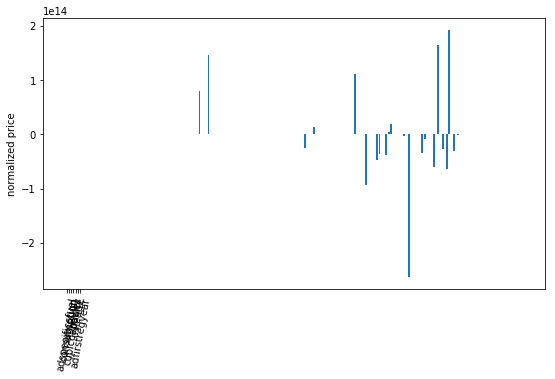

In [184]:
plt.figure(figsize=[9, 5])

plt.bar(range(len(LR1.coef_)), LR1.coef_)
plt.xticks(range(7), np.array(keys)[[2, 3, 4, 5, 6, 7, 12]], rotation=80)
plt.ylabel('normalized price')
plt.show()


In [185]:
LR1.intercept_, LR1.coef_

(-677273419166.49927,
 array([  3.30241512e-02,  -6.94513189e-02,  -1.19933778e-02,
          2.73111321e-02,   5.14727030e-01,  -5.28704771e-01,
          9.35468326e-01,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.58678946e+10,
          2.58678946e+10,   2.58678946e+10,   2.

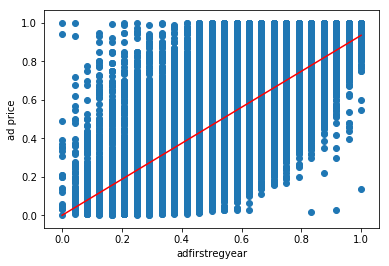

In [186]:
i=7
plt.scatter(normalized[:, i], normalized[:, 0])

plt.plot(np.arange(0, 1.1, 0.1), [j*LR1.coef_[i-1] for j in np.arange(0, 1.1, 0.1)], color='r')

plt.xlabel(keys[categoryList[i+5]])
#plt.xlabel('year first registered')
plt.ylabel('ad price')
plt.show()

In [157]:
i=5
[LR1.intercept_+ j * LR1.coef_[i-1] for j in np.arange(0, 1, 0.1)]

[-0.2195696487469917,
 -0.15404720727891158,
 -0.088524765810831463,
 -0.023002324342751318,
 0.042520117125328771,
 0.10804255859340889,
 0.17356500006148906,
 0.23908744152956918,
 0.30460988299764924,
 0.37013232446572941]

In [189]:
from sklearn.svm import SVR

svm = SVR(kernel='linear', degree=3, gamma=0.1, tol=0.001, C=1.0)

svm.fit(train_set_x, train_set_y)

print(svm.score(train_set_x, train_set_y))
print(svm.score(test_set_x, test_set_y))

0.813956953667
0.794330718018


In [190]:
print(svm.score(validate_set_x, validate_set_y))

0.790626153899


In [123]:
#validate_set_x = normalized[oneThird*2:, 2:].astype('float')
#validate_set_y = list(noNones2[oneThird*2:, 1].astype('int'))

print(svm.score(validate_set_x, validate_set_y))

0.79056473672


In [124]:
svm.support_vectors_.shape

(10578, 203)

In [195]:
from sklearn.svm import SVR

poly_svm = SVR(kernel='poly', degree=5, gamma=0.1, tol=0.001, C=10.0)

poly_svm.fit(train_set_x, train_set_y)

print(poly_svm.score(train_set_x, train_set_y))
print(poly_svm.score(test_set_x, test_set_y))

0.550688521314
0.528848322061


In [194]:
print(poly_svm.score(validate_set_x, validate_set_y))

0.654677355609
